<span style="color:red">
Note: This should not be merged into python-neo, but helps me figure out how to write axonarawio.py. I will add it to the axonarawio branch for now, but should delete it before a PR!
</span>.


# Read axona .bin file

We will go through the steps for reading in Axona dacqUSB system .bin data in continuous format.
The goal is to later implement this in axonarawio.py.

Here is the relevant information from the dacqUSB manual (found here: http://space-memory-navigation.org/DacqUSBFileFormats.pdf):


### Header
The header consists of:
* 4 bytes ID (will be "ADU1", unless the tracker position record is populated with valid data,
in which case it will be "ADU2")
* 4 bytes packet number
* 2 bytes digital inputs
* 2 bytes sync inputs
* 20 bytes tracker position record (only valid data if packet ID is "ADU2") -- same format as
standard .pos file position records.

### Data
Then there are three samples x 64 channels x 16-bits (= 384 bytes), followed by 16
dummy bytes at the end to make up the total packet length of 432. The samples order is
given below. Each sample is two bytes long, in 2's complement.
The data are stored at 48 kHz, so you should have 16000 packets of 432 bytes per second
of recording. Yes, this is very inefficient because you don't have anywhere near 64
channels so it is mostly wasted space; this will be improved in a future version update.
The main complication is that the order of the channels in the data file is not something
nice like 1,2,3, ... Instead, there is a remapping function:
<p>
remap_channels : array [1..64] of word = (
 32, 33, 34, 35, 36, 37, 38, 39,
 0, 1, 2, 3, 4, 5, 6, 7,
 40, 41, 42, 43, 44, 45, 46, 47,
 8, 9, 10, 11, 12, 13, 14, 15,
 48, 49, 50, 51, 52, 53, 54, 55,
 16, 17, 18, 19, 20, 21, 22, 23,
 56, 57, 58, 59, 60, 61, 62, 63,
 24, 25, 26, 27, 28, 29, 30, 31 ); 
</p>

For instance, if you want to find the data for channel 7, you look at remap_channels[7],
which is 38. So, in the 432-byte packet, you ignore the 32 byte header, and the data for
channel 7 will be at:
* bytes 32(header)+(38*2), and 32+(38*2+1) (first sample low and high bytes)
* bytes 32(header)+128(first samples, 64 ch x 2 bytes)+(38*2), and 32+128+(38*2+1) (2nd sample) 
* bytes 32+128+128+(38*2), and 32+128+128+(38*2+1) (third sample) and so on.

### Trailer
Finally, the trailer consists of 16 bytes:
2 bytes contain a record of digital output values
2 bytes contain stimulator status
10 bytes of zeroes (reserved for future use)
2 bytes contain the ASCII keycode if a key was pressed during the time the packet was
active. 

In [1]:
# Imports

import os
import mmap  # python library for memory mapping
import numpy as np  # contains np.memmap for memory mapping (used in python-neo)
import contextlib  # useful for managing contexts

In [2]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'
suffix = '.bin'

bin_file = os.path.join(dir_name, base_filename + suffix)

print(bin_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin


In [3]:
# We will also need the .set file later for info about the recording setup.

suffix = '.set'

set_file = os.path.join(dir_name, base_filename + suffix)

print(set_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.set


In [4]:
# Read the first 432 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

Note the substantial amount of wasted space (always assuming 64 channels)

In [5]:
# Read the first 432 * 2 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432 * 2)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

At a glance it seems sensible to use f.read() 432 byte snippet by 432 byte snippet since there is no global header or footer. 
Note that the pointer moves with every call to f.read(), if I want to reset it to the beginning I could use f.seek(0)

In [6]:
# How many 432 byte packets does this data contain (<=> num. samples / 3)?

bytes_per_packet = 432

with open(bin_file, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as mmap_obj:
        num_packets = int(len(mmap_obj)/bytes_per_packet)
        print(num_packets)
        

9600100


In [7]:
# Windows tells me the .bin file is 4147243200  bytes

print('Bytes according to mmap_obj:', num_packets * bytes_per_packet)
print('Bytes according to Windows OS:', 4147243200)

assert(num_packets * bytes_per_packet == 4147243200)

Bytes according to mmap_obj: 4147243200
Bytes according to Windows OS: 4147243200


In [8]:
# Try with np.memmap instead (used a lot in python-neo)

global_header_size = 0
raw_data = np.memmap(bin_file, dtype='int16', mode='r', offset=global_header_size)

print('Size of raw_data:', len(raw_data))
print('Peak at raw_data:', raw_data[16:26])
print('Type of raw_data:', type(raw_data))

Size of raw_data: 2073621600
Peak at raw_data: [ -4384  -6024  -4552 -13192  -7572  -5500    798   2378   1886  -7572]
Type of raw_data: <class 'numpy.memmap'>


In [161]:
# Get data with code snippet from BinConverter, using mmap library:
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/readBin.py

# 1second = 48000 samples
# 1packet = 3 samples
num_test_samples = 48000 // 3 #num_packets  # read only 1s for testing purposes

bytes_packet = 432
bytes_data = 384
bytes_head = 32
bytes_tail = 16

with open(bin_file, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as mmap_obj:
        num_packets = int(len(mmap_obj)/bytes_packet)

        data = np.ndarray(shape=(num_test_samples,), 
                          dtype=(np.int16, (bytes_data//2)),  # replace num_test_samples with num_packets
                          buffer=mmap_obj[0:bytes_packet*num_test_samples],  # ultimately read all
                          offset=bytes_head, 
                          strides=(bytes_packet,)).reshape((-1, 1)).flatten()

In [162]:
def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'

    with open(set_filename, encoding='cp1252') as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_') + 1:])
                    active_tetrode.append(tet_number)

    return active_tetrode

In [163]:
def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode)  # just in case the user gave a string as the tetrode

    return np.arange(1, 5) + 4 * (tetrode - 1)

In [164]:
active_tetrode_set = get_active_tetrode(set_file)
get_channel_from_tetrode(2)

array([5, 6, 7, 8])

In [165]:
def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)

    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)

    # return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

In [166]:
def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""

    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5,
                               6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11,
                               12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17,
                               18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63,
                               24, 25, 26, 27, 28, 29, 30, 31])

    return remap_channels[chan_num - 1]

In [167]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""

    if channels == []:
        channels = np.arange(64) + 1
    else:
        channels = np.asarray(channels)

    A = np.asarray(A)

    sample_num = int(len(A) / 64)  # get the sample numbers

    sample_array = np.zeros((len(channels), sample_num))  # creating a 64x3 array of zeros (64 channels, 3 samples)

    for i, channel in enumerate(channels):
        sample_array[i, :] = A[get_sample_indices(channel, sample_num)]

    return sample_array

In [168]:
arr = samples_to_array(data, channels = [])

In [169]:
arr.shape

(64, 48000)

In [174]:
arr

array([[ 3682., -3870.,     0., ...,  3890.,  -136., -4538.],
       [ 1714.,  -188.,     0., ...,  1306.,  -736., -3426.],
       [10480.,  5308.,     0., ..., -4060., -5640., -7398.],
       ...,
       [ 5406.,  4580.,     0., ...,     0.,     0.,     0.],
       [-4102.,  1742.,     0., ...,     0.,     0.,     0.],
       [ 3574.,  -230.,     0., ...,     0.,     0.,     0.]])

In [176]:
import matplotlib.pyplot as plt

def plot_data_snippet(x, start_idx=0, end_idx=len(x), Fs=48000, Nch=16):
    """Plot a data snippet from a Ch x samples array given a start index and
    end index. If Fs is supplied the x-axis is in seconds."""
    plt.figure(figsize=(16,8))

    x = np.linspace(0, (end_idx-start_idx)/Fs, end_idx-start_idx)

    for irow in range(0, Nch):
        plt.plot(x.T, 80000*irow+t1[irow,start_idx:end_idx], label='Ch'+str(irow))

    plt.xlabel("seconds", fontsize=20)
    plt.ylabel("channels", fontsize=20)
    plt.title("Example snippet of LFP data", fontsize=20)
    plt.show()

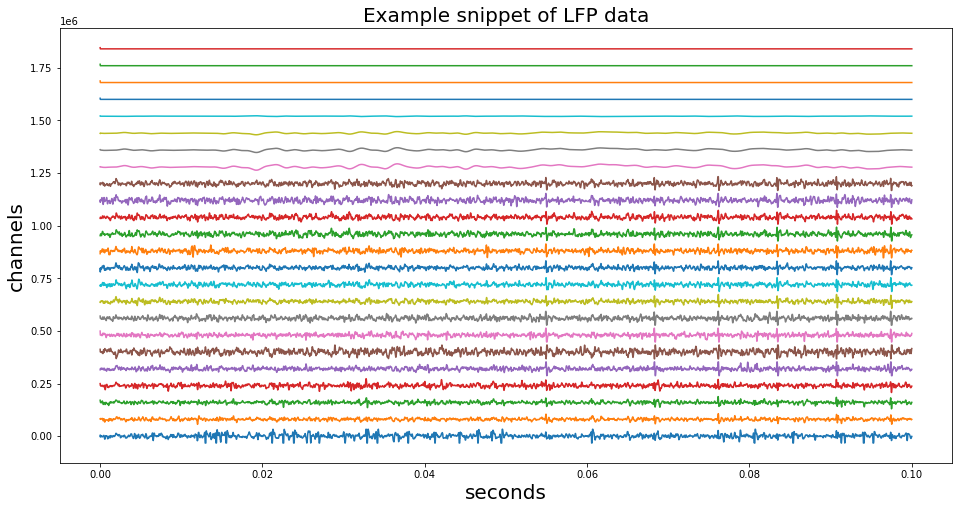

In [177]:
plot_data_snippet(arr, start_idx=0, end_idx=4800, Fs=48000, Nch = 24)

Why is there activity in channels 17-19 (just above the "normal" looking signals)?!

Should we use np.memmap and extract the data of interest in other functions of python-neo (e.g. in `_get_analogsignal_chunk`), or do we extract the array of data right away in `_parse_header`?

# Implement AxonaRawIO (step by step)

In [10]:
import neo.rawio

r = neo.rawio.ExampleRawIO(filename='itisafake.nof')
r.parse_header()
print(r)

ExampleRawIO: itisafake.nof
nb_block: 2
nb_segment:  [2, 3]
signal_channels: [ch0, ch1, ch2, ch3 ... ch12 ch13 ch14 ch15]
unit_channels: [unit0, unit1, unit2]
event_channels: [Some events, Some epochs]



In [178]:
# Have a look at the .set file 
# Encoding is cp1252, even though it's supposed to be ascii

with open(set_file, 'r', encoding='cp1252') as f:
    rec_info = f.read()

print(rec_info)

trial_date Sunday, 4 Oct 2020
trial_time 11:07:07
experimenter Abid
comments 
duration 600.00625
sw_version 1.2.2.16
ADC_fullscale_mv 1500
tracker_version 0
stim_version 1
audio_version 0
gain_ch_0 10000
filter_ch_0 2
a_in_ch_0 0
b_in_ch_0 5
mode_ch_0 4
filtresp_ch_0 0
filtkind_ch_0 0
filtfreq1_ch_0 0
filtfreq2_ch_0 0
filtripple_ch_0 0.00
filtdcblock_ch_0 0
dispmode_ch_0 1
channame_ch_0 
gain_ch_1 10000
filter_ch_1 2
a_in_ch_1 1
b_in_ch_1 5
mode_ch_1 4
filtresp_ch_1 0
filtkind_ch_1 0
filtfreq1_ch_1 0
filtfreq2_ch_1 0
filtripple_ch_1 0.00
filtdcblock_ch_1 0
dispmode_ch_1 1
channame_ch_1 
gain_ch_2 10000
filter_ch_2 2
a_in_ch_2 2
b_in_ch_2 5
mode_ch_2 4
filtresp_ch_2 0
filtkind_ch_2 0
filtfreq1_ch_2 0
filtfreq2_ch_2 0
filtripple_ch_2 0.00
filtdcblock_ch_2 0
dispmode_ch_2 1
channame_ch_2 
gain_ch_3 10000
filter_ch_3 2
a_in_ch_3 3
b_in_ch_3 5
mode_ch_3 4
filtresp_ch_3 0
filtkind_ch_3 0
filtfreq1_ch_3 0
filtfreq2_ch_3 0
filtripple_ch_3 0.00
filtdcblock_ch_3 0
dispmode_ch_3 1
channame_ch_3 


In [179]:
from neo.rawio.baserawio import (BaseRawIO, _signal_channel_dtype, _unit_channel_dtype,
                        _event_channel_dtype)
import numpy as np

In [193]:
import re

Read date and time of recording into datetime object

In [212]:
with open(set_file, 'r', encoding='cp1252') as f:
    for line in f:
        if line.startswith('trial_date'):
            date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
        if line.startswith('trial_time'):
            time_string = line[len('trial_time')+1::].replace('\n', '')

In [229]:
date_object = datetime.strptime(date_string + ', ' + time_string, "%d %b %Y, %H:%M:%S")
date_object

datetime.datetime(2020, 10, 4, 11, 7, 7)

In [189]:
time_object = datetime.strptime(time_string)


TypeError: strptime() takes exactly 2 arguments (1 given)

In [188]:
# When was the recording made?
# trial_date Sunday, 4 Oct 2020
# trial_time 11:07:07

from datetime import datetime

date_object = datetime.strptime(date_string, "%d %B, %Y")
time_object = datetime.strptime(time_string)
print("date_object =", date_object)
print("type of date_object =", type(date_object))

rec_datetime = datetime.datetime(rec_info['Year'],
                                 global_header['Month'],
                                 global_header['Day'],
                                 global_header['Hour'],
                                 global_header['Minute'],
                                 global_header['Second'])

ValueError: time data 'Sunday, 4 Oct 2020' does not match format '%d %B, %Y'

In [180]:
# The first few entries of header are straightforward,
# since we do not have separate blocks or segments (the recording is continuous)

header = {}
header['nb_block'] = 1
header['nb_segment'] = [1]

In [14]:
# Example from examplerawio.py for sig_channels

# create signals channels information
# This is mandatory!!!!
# gain/offset/units are really important because
# the scaling to real value will be done with that
# at the end real_signal = (raw_signal* gain + offset) * pq.Quantity(units)
sig_channels = []
for c in range(16):
    ch_name = 'ch{}'.format(c)
    # our channel id is c+1 just for fun
    # Note that chan_id should be realated to
    # original channel id in the file format
    # so that the end user should not be lost when reading datasets
    chan_id = c + 1
    sr = 10000.  # Hz
    dtype = 'int16'
    units = 'uV'
    gain = 1000. / 2 ** 16
    offset = 0.
    # group_id isonly for special cases when channel have diferents
    # sampling rate for instance. See TdtIO for that.
    # Here this is the general case :all channel have the same characteritics
    group_id = 0
    sig_channels.append((ch_name, chan_id, sr, dtype, units, gain, offset, group_id))
sig_channels = np.array(sig_channels, dtype=_signal_channel_dtype)

In [15]:
sig_channels

array([('ch0',  1, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch1',  2, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch2',  3, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch3',  4, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch4',  5, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch5',  6, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch6',  7, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch7',  8, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch8',  9, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch9', 10, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch10', 11, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch11', 12, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch12', 13, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch13', 14, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch14', 15, 10000., 'int16', 'uV', 0.01525879, 0., 0),
       ('ch15', 16, 10000., 'int16', 'uV', 0.01525879, 0., 0)],
 

In [ ]:
# Extract channel names and IDs


In [ ]:
# Create my own sig_channels using the header file (.set)

header['signal_channels'] = sig_channels
header['unit_channels'] = unit_channels
header['event_channels'] = event_channels

In [ ]:
# signals

sig_channels = []
for c, chan_info in enumerate(self._ordered_channels):
    name = chan_info['native_channel_name']
    chan_id = c  # the chan_id have no meaning in intan
    if chan_info['signal_type'] == 20:
        # exception for temperature
        sig_dtype = 'int16'
    else:
        sig_dtype = 'uint16'
    group_id = 0
    sig_channels.append((name, chan_id, chan_info['sampling_rate'],
                        sig_dtype, chan_info['units'], chan_info['gain'],
                        chan_info['offset'], chan_info['signal_type']))
sig_channels = np.array(sig_channels, dtype=_signal_channel_dtype)

self._max_sampling_rate = np.max(sig_channels['sampling_rate'])
self._max_sigs_length = self._raw_data.size * self._block_size